<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/fully_dense_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# dataset build

In [13]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-03 22:28:09--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-03 22:28:10--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [             <=>    ]  33.20M  11.6MB/s    in 2.9s    

2021-03-03 22:28:13 (11.6 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]



In [14]:
!tar -xf MNIST.tar.gz


In [15]:
!ls MNIST/processed/

test.pt  training.pt


In [16]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [17]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

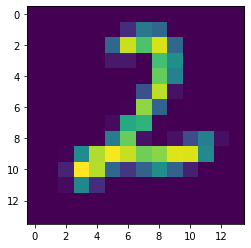

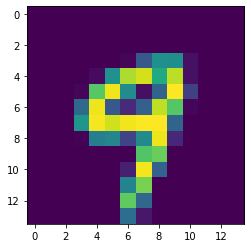

train shape : torch.Size([1000, 2, 14, 14])


In [18]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [19]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


In [20]:
for el in train_dataloader:
  # image , target, classes
  print(el[0].shape, el[1].shape, el[2].shape)
  break

torch.Size([100, 2, 14, 14]) torch.Size([100]) torch.Size([100, 2])


# FullyDenseNN

In [21]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

In [22]:
network = FullyDenseNet()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
criterion = F.binary_cross_entropy

In [23]:
def train_epoch(network_):
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer.zero_grad()
    output = network_(data).flatten()
    loss = criterion(output, target.to(torch.float32))
    loss.backward()
    optimizer.step()

    loss_tot.append(loss.item())
    acc_tot.append( (target == torch.round(output) ).sum().item() )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [24]:
def test(network_):
  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += criterion(output.flatten(), target.to(torch.float32)).item()
      acc += (target == torch.round(output.flatten()) ).sum().item()

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [25]:
def train(network ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network)
    test_loss , test_acc = test(network)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, train_loss , train_acc , test_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

In [26]:
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(network , 30)

0 0.86491858959198 0.5940000152587891 0.6289192378520966 0.688
1 0.5873011350631714 0.7130000305175781 0.5530600607395172 0.715
2 0.5069117546081543 0.759000015258789 0.5207778573036194 0.738
3 0.4581075608730316 0.7969999694824219 0.49693546295166013 0.747
4 0.4158394932746887 0.8130000305175781 0.48606942892074584 0.7509999999999999
5 0.3744216859340668 0.8319999694824218 0.4739769399166107 0.767
6 0.3313937783241272 0.865999984741211 0.4677602469921112 0.773
7 0.2861514985561371 0.8919999694824219 0.4749743819236755 0.7609999999999999
8 0.3087344765663147 0.8719999694824219 0.6252313852310181 0.731
9 0.3532920479774475 0.84 0.5721880853176117 0.74
10 0.27324602007865906 0.895 0.5284776270389557 0.76
11 0.19699275493621826 0.9330000305175781 0.502958607673645 0.774
12 0.12516312301158905 0.9640000152587891 0.5051301956176758 0.785
13 0.09040273725986481 0.980999984741211 0.5310131311416626 0.7809999999999999
14 0.06456239521503448 0.9940000152587891 0.5528793513774872 0.79
15 0.04328

In [27]:
def plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc ):
  epochs = range(1, len(tot_train_loss)+1 )
  plt.plot(epochs, tot_train_loss, 'g', label='Training loss')
  plt.plot(epochs, tot_test_loss, 'b', label='Test loss')
  plt.plot(epochs, tot_train_acc, 'r', label='Training acc')
  plt.plot(epochs, tot_test_acc, 'y', label='Test acc')
  plt.title('Training and Test loss/acc')
  plt.xlabel('Epochs')
  plt.ylabel('loss/acc')
  plt.ylim((0,1))
  plt.legend()
  plt.show()

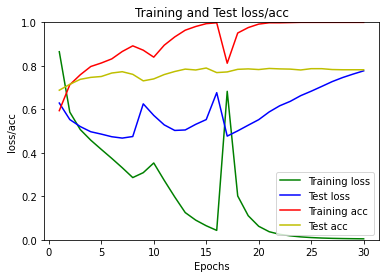

In [28]:
plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc )